In [1]:
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import numpy as np

Today, we will add a bias term to every layer. Last time, we ignored the bias term and only added it to the inputs. Now we will see how easy it is to add it to every layer with a small trick. 

In [2]:
# load the full dataset and display it
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print(train_y)

[5 0 4 ... 5 6 8]


In [3]:
print("Training Set Details")
print("Target Categories:", np.unique(train_y))
print("Features: ", train_X.shape, train_X.dtype)
print("Classes:", train_y.shape, train_y.dtype)

print("Classes:", train_y)
print("Feature range:", np.min(train_X).astype(np.int32), np.max(train_X).astype(np.int32))
print("Feature type:",train_X.dtype)
print("Target type:",train_y.dtype)

Training Set Details
Target Categories: [0 1 2 3 4 5 6 7 8 9]
Features:  (60000, 28, 28) uint8
Classes: (60000,) uint8
Classes: [5 0 4 ... 5 6 8]
Feature range: 0 255
Feature type: uint8
Target type: uint8


In [4]:
print("Test Set Details")
print("Target Categories:", np.unique(test_y))
print("Features: ", test_X.shape, test_X.dtype)
print("Classes:", test_y.shape, test_y.dtype)

print("Classes:", test_y)
print("Feature range:", np.min(test_X).astype(np.int32), np.max(test_X).astype(np.int32))
print("Feature type:",test_X.dtype)
print("Target type:",test_y.dtype)

Test Set Details
Target Categories: [0 1 2 3 4 5 6 7 8 9]
Features:  (10000, 28, 28) uint8
Classes: (10000,) uint8
Classes: [7 2 1 ... 4 5 6]
Feature range: 0 255
Feature type: uint8
Target type: uint8


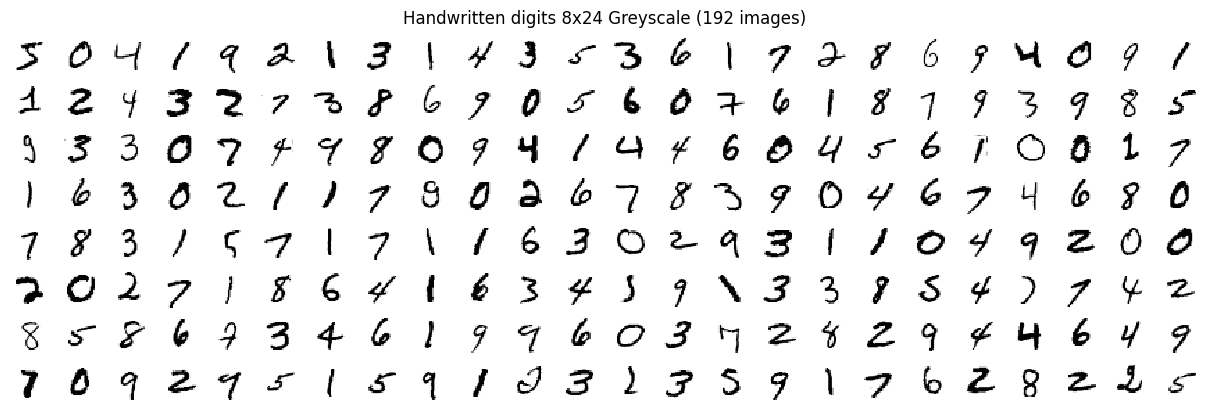

In [5]:
wsize = 24
hsize = 8
fig, axes = plt.subplots(hsize,wsize,figsize=(wsize/2,hsize/2),layout="constrained")

c = 0
for i in range(hsize):
    for j in range(wsize):
        axes[i][j].imshow(train_X[c].reshape((28,28)), interpolation='none', cmap=cm.Greys)
        axes[i][j].axis('off')
        c += 1
plt.suptitle(f"Handwritten digits {hsize}x{wsize} Greyscale ({wsize*hsize} images)")
plt.show()

In [6]:
def feature_scale(data_unscaled, scaled=True):
    if scaled == False:
        return data_unscaled

    max_value = np.max(data_unscaled)

    data_scaled = np.array(data_unscaled)
    data_scaled = data_scaled / max_value
    # min max normalization
    
    return data_scaled

train_X = feature_scale(train_X, scaled=True) # feature scale the training set
test_X = feature_scale(test_X, scaled=True) # feature scale the test set

In [7]:
train_size = train_X.shape[0]
test_size = test_X.shape[0]
train_X = train_X.reshape((train_size,-1)) # reshape the training set
test_X = test_X.reshape((test_size,-1)) # reshape the test set
print("TrainX:",train_X.shape)
print("TestX:",test_X.shape)

TrainX: (60000, 784)
TestX: (10000, 784)


Like last time, we still add a fake bias term to the input matrix. However, this isn't enough yet. 

In [8]:
def add_bias_weight(data):
    m = data.shape[0]
    ones_feature = np.ones(m).reshape((-1,1)) # create a single feature of ones
    data_bias = np.hstack([data, ones_feature])
    return data_bias

train_X_bias = add_bias_weight(train_X)
test_X_bias = add_bias_weight(test_X)
print("TrainX+Bias:",train_X_bias.shape)
print("TestX+Bias:",test_X_bias.shape)

TrainX+Bias: (60000, 785)
TestX+Bias: (10000, 785)


In [38]:
def initialize_mlp_weight_matrices(feature_size, layer_sizes): # TODO - Fix the bias term
    layer_sizes = np.array(layer_sizes)
    layer_sizes += 1
    layer_sizes[-1] -= 1
    # here add 1 to every layer for the bias term except the last layer since the last layer is the categories. 
    
    weight_matrices = []
    previous_layer_size = feature_size
    for layer_size in layer_sizes:
        weight_matrix = np.random.random((previous_layer_size, layer_size)) * 0.01 # make sure to use smarter initialization strategies
        weight_matrices.append(weight_matrix)
        previous_layer_size = layer_size
    return weight_matrices

This code above is interesting since adding a bias term is just an incrementation on the layer size. However, it can be even simpler than this since none of this needs to happen and the previous code will also work perfectly fine. I just explicity showed the addition of a new neuron per every hidden layer. 

In [10]:
def create_mini_batches(x, y, batch_size):
    size = x.shape[0]
    indices = np.arange(size)
    np.random.shuffle(indices)
    shuffled_x = np.take(x, indices, axis=0)
    shuffled_y = np.take(y, indices, axis=0)
    
    batches = size // batch_size
    minibatches_x = np.array_split(shuffled_x, batches)
    minibatches_y = np.array_split(shuffled_y, batches)

    return minibatches_x, minibatches_y

In [11]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [12]:
def softmax(x):
    D = -np.max(x, axis=1) # D constant for the log sum exp trick. Useful to deal with limited precision, but the output is the exact same as the original sigmoid

    ez = np.exp((x.T + D).T)
    return ez / np.sum(ez, axis=1).reshape((-1,1))

In [13]:
def predict(weight_matrices, batch_x, epsilon=1e-15):
    prediction = batch_x # m k
    for i in range(len(weight_matrices)):
        prediction = prediction @ weight_matrices[i] # matrix multiply by the previous output
        if i == len(weight_matrices) - 1: # at the very last layer don't apply sigmoid
            break
        prediction = sigmoid(prediction)

    softmax_predict = softmax(prediction) # pass it through a softmax
    prediction = np.clip(softmax_predict, epsilon, 1 - epsilon) # clip to avoid overflow issues
    return prediction

In [14]:
def onehot_matrix(a, categories):
    a = a.flatten()
    return np.eye(categories)[a]

In [15]:
def log_loss_cost(weight_matrices, x, y, categories):
    onehot = onehot_matrix(y, categories) # m k
    softmax_prob = predict(weight_matrices, x) # m k
    overk = onehot * np.log(softmax_prob) # m k
    overm = np.sum(overk, axis=1) # m
    return -np.mean(overm) # 1

The real trick comes below. Simply put, after every activation function operation on the weight matrix, we make every last neuron per each layer to be only 1. When you make it 1, the weight that gets assigned to it acts like a bias term. Hence, we avoid explicity backpropagating through the bias term which saves a lot of time. Of course, in numpy shapes every last neuron is essentially the last column of the matrix. So we just force these values to be exactly ones. 

In [44]:
def compute_gradients(weight_matrices, batch_x, batch_y, categories, epsilon=1e-15):
    m = batch_x.shape[0] # number of batched examples
    k = categories # number of categories

    gradient_matrices = []
    for weight_matrix in weight_matrices:
        gradient_matrices.append(np.zeros_like(weight_matrix))
    # create the gradient matrices

    onehot = onehot_matrix(batch_y, k) # m k
    # create the onehot labels

    W0 = batch_x @ weight_matrices[0]
    W0_sigmoid = sigmoid(W0) # layer 1 - 256
    W0_sigmoid[:, -1] = 1.0 # make the last column full of ones for bias term

    W1 = W0_sigmoid @ weight_matrices[1]
    W1_sigmoid = sigmoid(W1) # layer 2 - 128
    W1_sigmoid[:, -1] = 1.0 # make the last column full of ones for bias term

    prediction = W1_sigmoid @ weight_matrices[2] # layer 3 - 10

    softmax_prob = softmax(prediction) # pass it through a softmax
    softmax_prob = np.clip(softmax_prob, epsilon, 1 - epsilon) # clip to avoid overflow issues
    # compute the softmax probability matrix

    overk = onehot * np.log(softmax_prob) # m k
    overm = np.sum(overk, axis=1) # m
    loss = -np.mean(overm) # 1
    # compute the loss value

    diff = softmax_prob - onehot # m k
    dw2 = np.matmul(W1_sigmoid.T, diff) # 128 k
    dw1_sigmoid = np.matmul(diff, weight_matrices[2].T) # k 128
    dsigmoid = W1_sigmoid * (1 - W1_sigmoid) * dw1_sigmoid # k 128

    dw1 = np.matmul(W0_sigmoid.T, dsigmoid) # 256 128
    dw0_sigmoid = np.matmul(dsigmoid, weight_matrices[1].T) # k 256
    dsigmoid = W0_sigmoid * (1 - W0_sigmoid) * dw0_sigmoid # k 256

    dw0 = np.matmul(batch_x.T, dsigmoid) # n 256
    # begin the backpropagation

    gradient_matrices[0] = dw0
    gradient_matrices[1] = dw1
    gradient_matrices[2] = dw2
    # assign the gradient matrices to the array of matrices

    gradient_matrices[0] = np.clip(gradient_matrices[0], -1.0, 1.0)
    gradient_matrices[1] = np.clip(gradient_matrices[1], -1.0, 1.0)
    gradient_matrices[2] = np.clip(gradient_matrices[2], -1.0, 1.0)
    # before returning the gradient matrices, let's clip them between -1 and 1 to avoid exploding gradients

    return gradient_matrices

In [17]:
def show_cost_graph(costs, title, color):
    iterations = costs.shape[0]
    iteration_array = np.arange(0, iterations, dtype=np.int32)
    
    # graph the cost after updating the model
    _, cost_graph = plt.subplots(layout='constrained')
    
    cost_graph.set_xlabel("Batch")
    cost_graph.set_ylabel("Cost")
    
    cost_graph.set_title(title)
    
    cost_graph.plot(iteration_array, costs, color=color)

In [45]:
def gradient_descent(x, y, gradient_func, cost_func, layer_sizes, learning_rate=0.01, max_epochs=1000, batch_size=64):
    y = y.reshape((-1,1)) # output classes
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    k = np.unique(y).shape[0] # number of categories

    weight_matrices = initialize_mlp_weight_matrices(n, layer_sizes) # initialize weight matrices for each layer

    costs = np.empty(0)

    for epoch in range(max_epochs):
        minibatches_x, minibatches_y = create_mini_batches(x, y, batch_size)
        
        for batch_x, batch_y in zip(minibatches_x, minibatches_y):
            gradient_matrices = gradient_func(weight_matrices, batch_x, batch_y, k)

            for i in range(len(layer_sizes)):
                weight_matrices[i] -= learning_rate * gradient_matrices[i]
            # update the weights per each matrix
            
            current_cost = cost_func(weight_matrices, batch_x, batch_y, k)
            costs = np.append(costs, current_cost)
            # add to array for visualization
    return weight_matrices, costs

layer_sizes = [256,128,10]
weight_matrices, costs = gradient_descent(train_X_bias, train_y, compute_gradients, log_loss_cost, layer_sizes, learning_rate=0.01, max_epochs=40, batch_size=64)

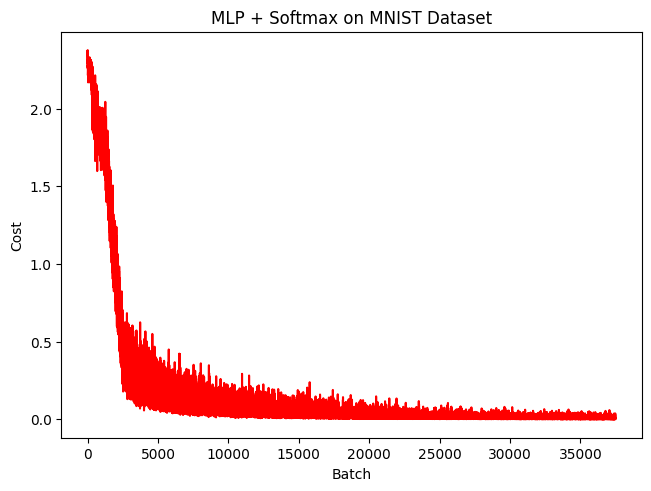

In [46]:
show_cost_graph(costs, "MLP + Softmax on MNIST Dataset", "red")

In [47]:
print("Initial cost",costs[0])
print("Final cost",costs[-1])

Initial cost 2.369490569576641
Final cost 0.0021232051707964516


In [21]:
def get_prediction_categories(probabilities):
    return np.argmax(probabilities,axis=1)

In [50]:
test_samples = test_X_bias.shape[0]
batches_x, batches_y = create_mini_batches(test_X_bias, test_y, 64)

prediction_test_set_categories = np.array([])
observed_test_set_categories = np.array([])

for batch_x, batch_y in zip(batches_x, batches_y):
    batch_prediction_prob = predict(weight_matrices, batch_x)
    batch_categories = get_prediction_categories(batch_prediction_prob)
    prediction_test_set_categories = np.append(prediction_test_set_categories, batch_categories)
    observed_test_set_categories = np.append(observed_test_set_categories, batch_y)

score_percentage = accuracy_score(observed_test_set_categories, prediction_test_set_categories) * 100
print("Accuracy:",round(score_percentage, 2),"%") # show accuracy till 2 decimal places
misclassifications = int(accuracy_score(observed_test_set_categories, prediction_test_set_categories, normalize=False))
print("misclassifications:",test_samples - misclassifications)

Accuracy: 98.0 %
misclassifications: 200


The accuracy is a bit higher clearly since we introduced the bias term for every layer manually. However, it's very close to the previous one where we only added a bias to the input image features. So I would say adding it didn't really help us in this situation. Regardless, adding a bias term is very simple and with this trick you don't need to write the backprop code for the bias manually. 